# Predict house price by its image

## Parameters

In [1]:
from pathlib import Path

# Directory of the csv 
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01')
# Images directory
IMAGES_DIR = BASE_DIR.joinpath('images','train')
# Csv file name
FILE_NAME = 'metadata.csv'
# Column name indicating the image path
PATH_COL = 'filename'
# f(X) = y <-- result column
LABEL_COL = 'class'

## Functions

### Timing and tone

In [2]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Outliers

In [3]:
from sklearn.ensemble import IsolationForest

def outliers(df,cols):
    outlier = IsolationForest(contamination=.04,n_jobs=-1)
    df['outlier'] = outlier.fit_predict(df[cols])
    df = df[df['outlier']!=-1].drop(columns = 'outlier')
    return df

### Collage from house pics

In [4]:
from PIL import Image
def collage(images_dir, canvas_size=(1024,768)):
    # Resize images from images_dir to fit there
    new_size = (int(canvas_size[0]/2), int(canvas_size[1]/2))
    images_list = [Image.open(x).resize(new_size) for x in images_dir]

    # Create a canvas and paste the images as a collage
    canvas = Image.new('RGB', canvas_size, (255,255,255))
    canvas.paste(images_list[0], (0,0))
    canvas.paste(images_list[1], (new_size[0],0))
    canvas.paste(images_list[2], (0,new_size[1]))
    canvas.paste(images_list[3], (new_size[0],new_size[1]))
    
    return canvas

### CNN builder

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, Dropout, LeakyReLU, BatchNormalization

def cnn_builder(train_set, layer_filters, cnn_activ, layer_units, seq_activ):
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=2, input_shape=train_set.image_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2))
    for i,(filters,activ) in enumerate(zip(layer_filters, cnn_activ)):
        model.add(Conv2D(filters, 2, activation=activ))
        if i%2!=0: model.add(BatchNormalization())
        model.add(MaxPool2D(2))
        model.add(Dropout(0.1))
    
    model.add(Flatten())
    
    for units,activa in zip(layer_units, seq_activ):
        model.add(Dense(units, activa))
    
    model.add(Dense(1, 'relu'))
    
    print(model.summary())
    return model

### Plot metrics

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(training_history,metrics=['loss','mean_squared_error']):
    #Show the trend of every metrics provided after training
    for metric in metrics:
        trend = training_history.history[metric]
        plt.figure()
        plt.plot(range(len(trend)), trend, 'r', label=f'Training {metric}')
        plt.title(f'Training {metric}')
    plt.show()

## Data Wrangling

### Import

In [7]:
import pandas as pd

# Importar csv como DataFrame
df = pd.read_csv(BASE_DIR.joinpath(FILE_NAME)).reset_index()
df = df[df['price']!=0].copy()
df['index'] = df['index']+1
df.head()

,index,n_rooms,n_bathrooms,area,zipcode,price
0,1,4,4.0,4053,85255,869500
1,2,4,3.0,3343,36372,865200
2,3,3,4.0,3923,85266,889000
3,4,5,5.0,4022,85262,910000
4,5,3,4.0,4116,85266,971226


### Check if there's the same number of images per house

In [8]:
import re
[x for x in IMAGES_DIR.glob('*') if re.search('(\/1)_\S+\.jpg',str(x))!=None]

[PosixPath('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01/images/train/1_frontal.jpg'),
 PosixPath('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01/images/train/1_kitchen.jpg'),
 PosixPath('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01/images/train/1_bathroom.jpg'),
 PosixPath('/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01/images/train/1_bedroom.jpg')]

In [9]:
df['images'] = df['index'].apply(lambda x: sorted([img for img in IMAGES_DIR.glob('*') if re.search(f'(\/{x})_\S+\.jpg',str(img))!=None]))
df['images'].apply(len).value_counts()

4    523
Name: images, dtype: int64

### Collage

In [10]:
IMAGES_DIR = BASE_DIR.joinpath('images','collage_train')

In [11]:
# for new_image, name in zip(df['images'].apply(collage), df['index']):
#     new_image.save(IMAGES_DIR.joinpath(str(name)+'_collage.jpg'), 'JPEG')

### Filename column

In [12]:
df[PATH_COL] = df['index'].astype(str)+'_collage.jpg'
df.sample()

,index,n_rooms,n_bathrooms,area,zipcode,price,images,filename
17,18,3,4.0,2748,85255,725000,[/Users/efraflores/Desktop/EF/Diplo/data/04/ex...,18_collage.jpg


### Outliers

<AxesSubplot:>

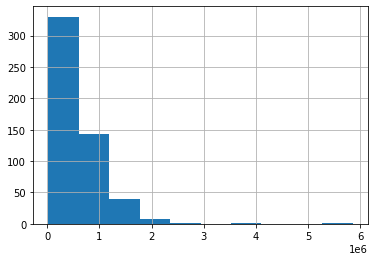

In [13]:
df['price'].hist()

<AxesSubplot:>

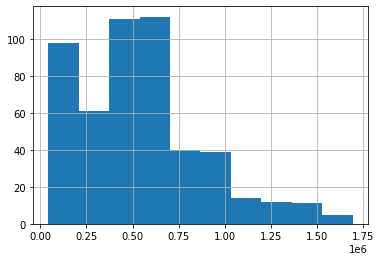

In [14]:
df = outliers(df, ['price'])
df['price'].hist()

### Scale price

In [15]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, train_size=0.7, random_state=22)

scaler = StandardScaler()

X_train['class'] = scaler.fit_transform(X_train[['price']])
X_test['class'] = scaler.transform(X_test[['price']])

/var/folders/j4/1p33_bh96yn8pdz3b_5t80hm0000gn/T/ipykernel_1302/25737350.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['class'] = scaler.fit_transform(X_train[['price']])
/var/folders/j4/1p33_bh96yn8pdz3b_5t80hm0000gn/T/ipykernel_1302/25737350.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['class'] = scaler.transform(X_test[['price']])


### Data Agumentation

In [16]:
aug = X_train.iloc[:5,:].copy().set_index('index')
aug = aug.join(aug['images'].apply(lambda x: str([str(y) for y in x]).replace('[','').replace(']','')).str.split(',', expand=True))
aug = aug.melt(id_vars='class', ignore_index=False, value_vars=[0,1,2,3], value_name='filename')
aug['filename'] = aug['filename'].str.split('/').str[-1].str.replace("'",'')
display(aug.head())

/var/folders/j4/1p33_bh96yn8pdz3b_5t80hm0000gn/T/ipykernel_1302/3986387986.py:3: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  aug = aug.melt(id_vars='class', ignore_index=False, value_vars=[0,1,2,3], value_name='filename')


,class,variable,filename
index,,,
475,0.206084,0,475_bathroom.jpg
533,-0.425558,0,533_bathroom.jpg
207,0.188699,0,207_bathroom.jpg
2,0.902049,0,2_bathroom.jpg
481,-0.648661,0,481_bathroom.jpg


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug_gen = ImageDataGenerator(
                            rescale=1./255,
                            shear_range=0.5,
                            zoom_range=0.5,
                            rotation_range=45
                            )
aug_set = aug_gen.flow_from_dataframe(aug, directory=BASE_DIR.joinpath('images','train'), class_mode='raw', save_to_dir=BASE_DIR.joinpath('images','augmented'), save_prefix='aug_', save_format='jpg')

Found 20 validated image filenames.


In [18]:
aug_model = cnn_builder(aug_set,[],[],[],[])

2021-08-14 21:50:24.304059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 40)      520       
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 40)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 40)      0         
_________________________________________________________________
flatten (Flatten)            (None, 645160)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 645161    
Total params: 645,841
Trainable params: 645,761
Non-trainable params: 80
_________________________________________________________________
None


In [19]:
# aug_model.compile(optimizer='adam', loss='mean_absolute_error')
# aug_model.fit(aug_set, epochs=1)

### Image Data Generator

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_args = {'directory':IMAGES_DIR, 'class_mode':'raw', 'batch_size':10, 'target_size':(int(1024*.12),int(768*.12)), 'seed':10}

train_gen = ImageDataGenerator(
                            rescale=1./255,
                            shear_range=0.11,
                            zoom_range=0.11,
                            rotation_range=11
                            )
training_set = train_gen.flow_from_dataframe(X_train, **gen_args)
testing_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(X_test, **gen_args)

Found 352 validated image filenames.
Found 151 validated image filenames.


## Model

### Arquitecture

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [22]:
model = cnn_builder(training_set,[50,40,30,20],['relu','relu','relu','relu'],[50,40,30,20],['relu','relu','relu','relu'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 91, 40)       520       
_________________________________________________________________
batch_normalization_1 (Batch (None, 121, 91, 40)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 45, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 44, 50)        8050      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 22, 50)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 22, 50)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 21, 40)       

### Compile

In [23]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=7e-5)
model.compile(optimizer=opt, loss='mean_absolute_error', metrics='mean_squared_error')

### Callbacks

#### Early Stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=22)

#### Checkpoints

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(BASE_DIR.joinpath('models/housemodel_{val_mean_squared_error:.3f}.h5'),
                            save_best_only=True,
                            save_weights_only=False,
                            monitor='val_mean_squared_error')

### Training

#### Fit

In [26]:
train_history = model.fit(training_set, validation_data=testing_set, epochs=100, callbacks=[early_stopping, checkpoint])

Epoch 1/100
36/36 [==============================] - 8s 196ms/step - loss: 0.7565 - mean_squared_error: 1.0001 - val_loss: 0.7560 - val_mean_squared_error: 0.9435
Epoch 2/100
36/36 [==============================] - 6s 169ms/step - loss: 0.7564 - mean_squared_error: 1.0000 - val_loss: 0.7574 - val_mean_squared_error: 0.9450
Epoch 3/100
36/36 [==============================] - 6s 169ms/step - loss: 0.7562 - mean_squared_error: 0.9996 - val_loss: 0.7575 - val_mean_squared_error: 0.9449
Epoch 4/100
36/36 [==============================] - 6s 178ms/step - loss: 0.7564 - mean_squared_error: 1.0000 - val_loss: 0.7595 - val_mean_squared_error: 0.9470
Epoch 5/100
36/36 [==============================] - 6s 180ms/step - loss: 0.7564 - mean_squared_error: 1.0000 - val_loss: 0.7599 - val_mean_squared_error: 0.9466
Epoch 6/100
36/36 [==============================] - 7s 191ms/step - loss: 0.7564 - mean_squared_error: 1.0000 - val_loss: 0.7608 - val_mean_squared_error: 0.9460
Epoch 7/100
36/36 [===

#### Metrics

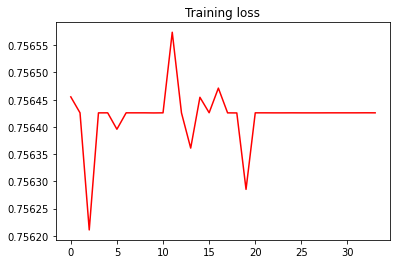

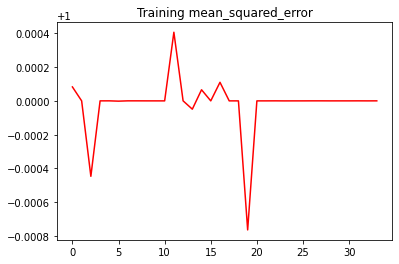

In [27]:
plot_metrics(train_history)

### Export

In [28]:
import pickle

with open(BASE_DIR.joinpath('house_scaler.xz'), 'wb') as f:
    pickle.dump(scaler, f)

In [29]:
import re
from keras.models import load_model

max_acc = min([str(x)[-9:-3] for x in BASE_DIR.joinpath('models').glob('**/*') if x.is_file() and str(x)[-8:]!='DS_Store'])
path_model = [x for x in BASE_DIR.joinpath('models').glob('**/*') if re.search(max_acc,str(x))!=None][0]
print(str(path_model))
best_model = load_model(path_model)

/Users/efraflores/Desktop/EF/Diplo/data/04/examen_01/models/housemodel_0.622.h5


In [30]:
best_model.save(BASE_DIR.joinpath('house_model.h5'))

## End

In [31]:
time_exp(time.time() - start)
tone()

4 minutos con 17.89 segundos
